In [106]:
%matplotlib notebook

import librosa
import numpy as np
import pylab as pl
import os

from sklearn.cluster import MeanShift, estimate_bandwidth  
from sklearn.cluster import KMeans

from utils import ZCA, wav2audio_segment

from sklearn import manifold 

In [107]:
path = "../wavs/"
fnames = os.listdir(path)
fnames = ["Xenakis_Metastasis.wav"]
fnames = ["Stockhausen_Kontakte.wav"]

cqt_n_bins = 60 * 2     
n_mfcc = 20
NFFT = 2**12
HOP = NFFT/2



n_components = 2

In [135]:
class Descriptor():
    
    function = None
    data = None
    params = None
    data = None
    
    def __init__(self,data):
        self.name = data['name']
        self.params = data['params']
        self.function = data['function']
        
    def set_func(self,func):
        self.function=func
        
    def perform(self,input_data):
        self.data = self.function(self,input_data)
#         return self.descriptor
        
DESCRIPTORS = [
{'name':'stft',
  'params': {"n_fft":NFFT, "hop_length":HOP},
  'function': lambda self,y: np.abs( librosa.stft(y,**self.params).T ) },

{'name': 'mfcc',
 'params': {'n_mfcc':n_mfcc,'sr':sr,"n_fft":NFFT, "hop_length":HOP},
 'function': lambda self,y: librosa.feature.mfcc(y, **self.params).T },
    
{'name': 'scontrast',
 'params': {'sr':sr,"n_fft":NFFT, "hop_length":HOP} ,
 'function' : lambda self,y: librosa.feature.spectral_contrast(y, **self.params).T },

{'name': 'chroma',
 'params':{'n_fft':NFFT,'hop_length':HOP} ,
 'function': lambda self, y: librosa.feature.chroma_stft(y, **self.params).T }]

In [136]:
class Manifold():
    
    function = None
    data = None
    params = None
    data = None
    
    def __init__(self,data):
        self.name = data['name']
        self.params = data['params']
        self.function = data['function']
        
    def set_func(self,func):
        self.function=func
        
    def perform(self,input_data):
        self.data = self.function(self,input_data)

n_neighbors = 10
        
MANIFOLDS = [
{'name':'LLE Mod',
  'params': {"n_neighbors":5, "eigen_solver":'auto',"method":"modified"},
  'function': lambda self,y: manifold.LocallyLinearEmbedding(**self.params).fit_transform(y) },

{'name': 'SpectralEmbedding',
 'params': {'n_components':5,'n_neighbors':n_neighbors},
 'function': lambda self,y: manifold.SpectralEmbedding(**self.params).fit_transform(y) },        
        
{'name': 'Isomap',
 'params': {'n_components':2,'n_neighbors':n_neighbors},
 'function': lambda self,y: manifold.Isomap(**self.params).fit_transform(y) }]


In [137]:
audio = {}
for fname in fnames:
    sr, signal  = wav2audio_segment(path+fname,60,80)

    ntotal = signal.size
    durtotal = ntotal/sr
    
    audio[fname] = {"D":[],"M":[]}
    
    for D in DESCRIPTORS:
        d = Descriptor(D)
        d.perform(signal)
        audio[fname]["D"].append( d )


/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


In [138]:
for fname in fnames:
    
    for d in audio[fname]["D"]:
        
        X = d.data
    
        for M in MANIFOLDS:
            m = Manifold(M)
            m.perform(X)
            audio[fname]["M"].append( ( d.name , m ) ) 
            

In [139]:

# for fname in fnames:
    
#     for n,m in audio[fname]["M"]:
        
#         Y = m.data

#         time_color = pl.cm.jet(np.linspace(0,1,Y.shape[0]))
#         pl.figure()
#         pl.subplot(2,1,1)
#         pl.scatter(Y[:, 0], Y[:, 1],c=time_color,alpha=0.4, edgecolors='none')
#         pl.title(n + ' ' + m.name)        

#         pl.subplot(2,1,2)
#         pl.plot(Y)                

#         pl.draw()      
        

<IPython.core.display.Javascript object>


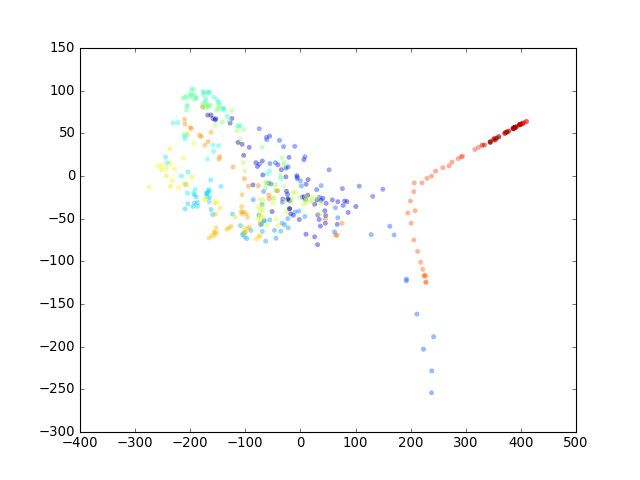

In [140]:
for fname in fnames:
    
    for n,m in audio[fname]["M"]:
        
        if n=='mfcc' and m.name == 'Isomap':
            
            Y = m.data

            time_color = pl.cm.jet(np.linspace(0,1,Y.shape[0]))
            pl.figure()
            pl.scatter(Y[:, 0], Y[:, 1],c=time_color,alpha=0.4, edgecolors='none')

In [164]:
punto = np.array([-0,-0])
d = np.linalg.norm(Y-punto,axis=1)
ix = np.where(d<30)[0]

framesix = np.array([np.arange(i,i+NFFT) for i in range(0,signal.size,int(HOP))])

fragments = signal[framesix[ix]]
fragments = fragments.reshape(fragments.size)

import IPython
IPython.display.Audio(data=fragments,rate=sr)

In [ ]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
scatter_matrix(pd.DataFrame(Y), alpha=0.2, figsize=(12, 12))

In [ ]:
import sompy as SOM
